<a href="https://colab.research.google.com/github/eyaguirat10/Explainable-AI-Workshop/blob/main/Notebook_XAI_Eya_Guirat_4DS10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Explainable AI Workshop***

---



# **Objectives:**

* Build a machine learning model to predict customer churn.

* Perform a global explanation of the model's behavior using an appropriate global explanation method.

* Conduct a local analysis to explain individual predictions using a suitable local explanation technique.


**Customer Churn dataset:**

The aim is to estimate whether a bank's customers leave the bank or not.

The event that defines the customer abandonment is the closing of the customer's bank account.

**Data Set Story:**
It consists of 10000 observations and 12 variables.
Independent variables contain information about customers.
Dependent variable refers to customer abandonment.
**Features:**
* Surname: Surname
* CreditScore: Credit score
* Geography: Country (Germany / France / Spain)
* Gender: Gender (Female / Male)
* Age: Age
* Tenure: How many years of customer
* Balance: Balance
* NumOfProducts: Bank product used
* HasCrCard: Credit card status (0 = No, 1 = Yes)
* IsActiveMember: Active membership status (0 = No, 1 = Yes)
* EstimatedSalary: Estimated salary
* Exited: Abandoned or not? (0 = No, 1 = Yes)


In [6]:
!pip install lime

In [7]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import shap
import lime
import lime.lime_tabular

# Print XAI definition
print("Explainable AI (XAI): Methods and techniques that make AI systems' decisions more transparent and interpretable to humans.")

Explainable AI (XAI): Methods and techniques that make AI systems' decisions more transparent and interpretable to humans.


In [8]:
# read data
data = pd.read_csv('churn_problem.csv')
data.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [9]:
data.shape

(10000, 14)

In [10]:
data = data.drop(['RowNumber', 'CustomerId','Surname'], axis=1)


In [11]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [12]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
data['Geography']= label_encoder.fit_transform(data['Geography'])

data['Geography'].unique()

array([0, 2, 1])

In [13]:
label_encoder = preprocessing.LabelEncoder()
data['Gender']= label_encoder.fit_transform(data['Gender'])

data['Gender'].unique()

array([0, 1])

In [14]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


In [15]:
# data = data.select_dtypes(exclude=['object'])


In [16]:
# Split the data
X = data.drop('Exited', axis=1)
y = data['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
print("Preprocessed data shape:", X.shape)
print("Target variable distribution:")
print(y.value_counts(normalize=True))

Preprocessed data shape: (10000, 10)
Target variable distribution:
Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64


* 0 = the customer has not left (no "Exited")

* 1 = the customer has left (yes "Exited")

In [18]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


In [19]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  int64  
 2   Gender           10000 non-null  int64  
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
dtypes: float64(2), int64(8)
memory usage: 781.4 KB


In [20]:
X_test.shape

(2000, 10)

#Interpretable ML

##Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Train the model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predictions
y_pred_lr = log_reg.predict(X_test)

# Evaluation
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      1607
           1       0.60      0.19      0.29       393

    accuracy                           0.82      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.79      0.82      0.78      2000

Confusion Matrix:
[[1556   51]
 [ 317   76]]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##Global Explanation

In [33]:
import pandas as pd
import numpy as np

# Extract feature names and coefficients
coefficients = log_reg.coef_[0]
feature_importance_lr = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", ascending=False)

feature_importance_lr


,Feature,Coefficient
1,Geography,2.520359e-01
3,Age,6.358505e-02
5,Balance,4.018188e-06
9,EstimatedSalary,-5.210544e-07
0,CreditScore,-2.639204e-03
4,Tenure,-3.173269e-02
6,NumOfProducts,-8.923438e-02
7,HasCrCard,-1.247477e-01
2,Gender,-5.069731e-01
8,IsActiveMember,-1.129779e+00


<Axes: title={'center': 'Logistic Regression Coefficients'}, ylabel='Feature'>

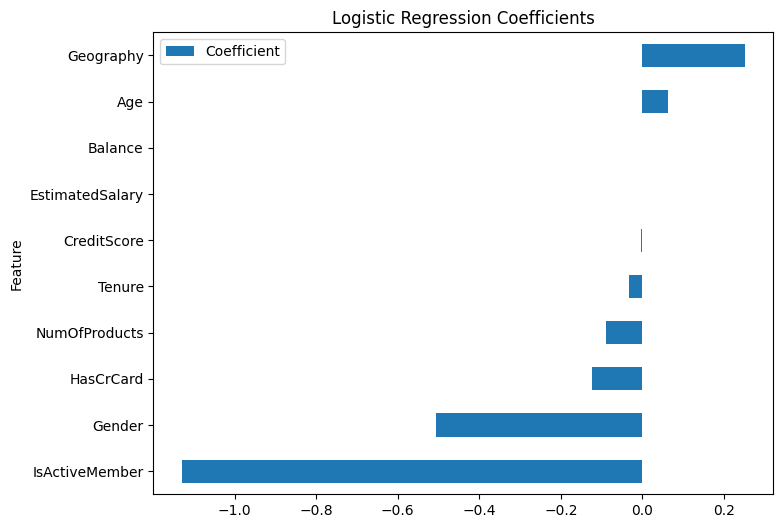

In [34]:
feature_importance_lr.sort_values("Coefficient", ascending=True).plot(
    x="Feature", y="Coefficient", kind="barh", figsize=(8,6),
    title="Logistic Regression Coefficients"
)


this observation reveals that Geography, IsActiveMember and Gender are the main contributors to churn prediction. Positive coefficients increase the probability of churn, while negative coefficients strongly reduce churn risk. Some features such as CreditScore and EstimatedSalary have almost no linear effect, which explains why Logistic Regression performs differently from the Random Forest model.

##Local Explanation

In [35]:
i = 0
single_example = X_test.iloc[i]

print("Selected customer data:")
print(single_example)

# Compute contribution = feature_value * coefficient
contribution = single_example * coefficients

local_explanation = pd.DataFrame({
    "Feature": X.columns,
    "Value": single_example.values,
    "Coefficient": coefficients,
    "Contribution": contribution
}).sort_values(by="Contribution", ascending=False)

local_explanation


Selected customer data:
CreditScore          596.00
Geography              1.00
Gender                 1.00
Age                   32.00
Tenure                 3.00
Balance            96709.07
NumOfProducts          2.00
HasCrCard              0.00
IsActiveMember         0.00
EstimatedSalary    41788.37
Name: 6252, dtype: float64


,Feature,Value,Coefficient,Contribution
Age,Age,32.00,6.358505e-02,2.034722
Balance,Balance,96709.07,4.018188e-06,0.388595
Geography,Geography,1.00,2.520359e-01,0.252036
IsActiveMember,IsActiveMember,0.00,-1.129779e+00,-0.000000
HasCrCard,HasCrCard,0.00,-1.247477e-01,-0.000000
EstimatedSalary,EstimatedSalary,41788.37,-5.210544e-07,-0.021774
Tenure,Tenure,3.00,-3.173269e-02,-0.095198
NumOfProducts,NumOfProducts,2.00,-8.923438e-02,-0.178469
Gender,Gender,1.00,-5.069731e-01,-0.506973
CreditScore,CreditScore,596.00,-2.639204e-03,-1.572965


#Explainable ML

##Random Forest

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.fit_transform(X_test)

In [22]:
# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Evaluate the model
test_accuracy = rf_classifier.score(X_test, y_test)

# print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

Test accuracy: 0.8645


###**Global Explanation**

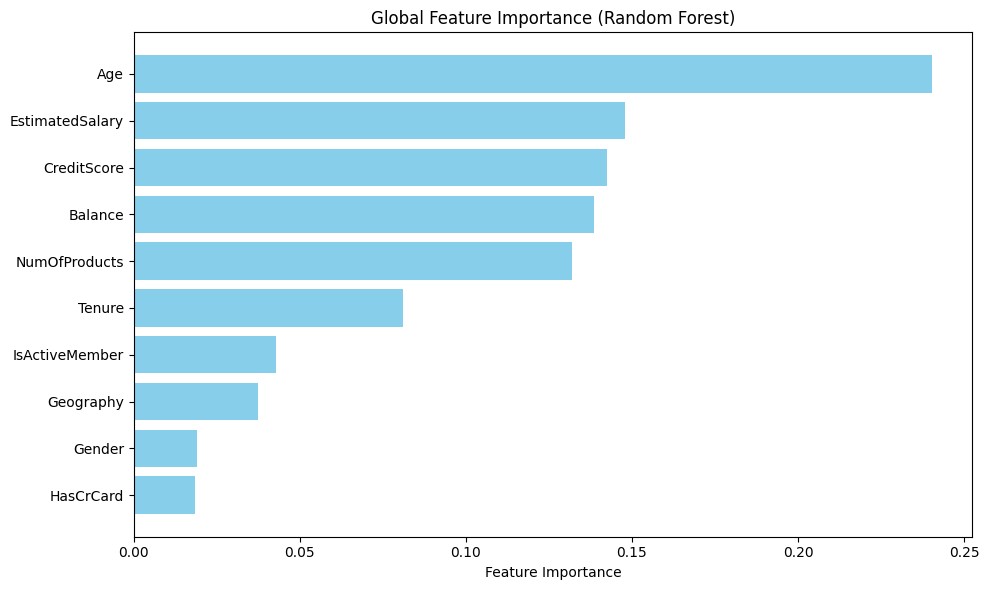

In [23]:
import matplotlib.pyplot as plt
# Get feature importances
importances = rf_classifier.feature_importances_
features = X.columns

# Plot top 10 important features
top_indices = importances.argsort()[::-1][:10]
plt.figure(figsize=(10, 6))
plt.barh(features[top_indices][::-1], importances[top_indices][::-1], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Global Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()

###**Local Explanation**

In [24]:
# # Create a LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['No', 'Exited'],
    mode='classification'
)


# # Plot the LIME explanation
# lime_exp.as_pyplot_figure()


In [25]:
# Demonstrating explanation stability
instance1 = X_test.iloc[0]
instance2 = X_test.iloc[1731]

In [26]:
y_test.iloc[0]

np.int64(0)

In [27]:
y_test.iloc[1731]

np.int64(1)

In [28]:
# LIME explanations
exp1 = lime_explainer.explain_instance(instance1.values, rf_classifier.predict_proba, num_features=5)
exp2 = lime_explainer.explain_instance(instance2.values, rf_classifier.predict_proba, num_features=5)

print("LIME explanation for instance 1:")
print(exp1.as_list())
print("\nLIME explanation for instance 2:")
print(exp2.as_list())

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


LIME explanation for instance 1:
[('Age <= 32.00', -0.1684011462297521), ('1.00 < NumOfProducts <= 2.00', -0.1590904614456797), ('IsActiveMember <= 0.00', 0.1287160407436403), ('0.00 < Gender <= 1.00', -0.0426289624938701), ('0.00 < Geography <= 1.00', 0.03414527310414871)]

LIME explanation for instance 2:
[('Age > 44.00', 0.32786184756242487), ('IsActiveMember <= 0.00', 0.1389689585629227), ('NumOfProducts <= 1.00', 0.08992769193360957), ('0.00 < Gender <= 1.00', -0.053134999597550754), ('Balance <= 0.00', -0.02347831930533287)]


In [29]:
# # Generate a LIME explanation for a single instance
instance = X_test.iloc[0]
# lime_exp = lime_explainer.explain_instance(instance.values, rf_classifier.predict_proba, num_features=10)


In [30]:
# Generate LIME explanation for both classes
lime_exp = lime_explainer.explain_instance(
    instance1.values,
    rf_classifier.predict_proba,
    num_features=10,
    labels=[0, 1]  # Force explanation for both classes
)

# Now display both
for label in [0, 1]:
    print(f"\nExplanation for class {lime_exp.class_names[label]}:")
    for feature, weight in lime_exp.as_list(label=label):
        print(f"{feature}: {weight}")



Explanation for class No:
Age <= 32.00: 0.1681010433803803
1.00 < NumOfProducts <= 2.00: 0.1617902418698148
IsActiveMember <= 0.00: -0.1378130123411792
0.00 < Gender <= 1.00: 0.05749515252521579
0.00 < Geography <= 1.00: -0.04414492677337833
96447.52 < Balance <= 127611.33: -0.023404029277700036
585.00 < CreditScore <= 653.00: -0.005890787013126268
EstimatedSalary <= 51364.12: -0.005799564838275791
Tenure <= 3.00: -0.005749327308225837
HasCrCard <= 0.00: 0.0024323252964866676

Explanation for class Exited:
Age <= 32.00: -0.16810104338038026
1.00 < NumOfProducts <= 2.00: -0.1617902418698148
IsActiveMember <= 0.00: 0.1378130123411792
0.00 < Gender <= 1.00: -0.057495152525215754
0.00 < Geography <= 1.00: 0.044144926773378335
96447.52 < Balance <= 127611.33: 0.023404029277700036
585.00 < CreditScore <= 653.00: 0.005890787013126268
EstimatedSalary <= 51364.12: 0.005799564838275781
Tenure <= 3.00: 0.005749327308225849
HasCrCard <= 0.00: -0.002432325296486659


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Les valeurs positives dans une classe favorisent cette classe.

Les valeurs négatives sont en faveur de l’autre classe.

Les grandes valeurs absolues indiquent une forte influence sur la décision.

Condition | Impact sur**"Exited"**

Jeune âge → -0.1689 | Moins probable de quitter

Inactif → +0.1257 | Plus probable de quitter

Num produits bancaires modérés → -0.1535 | Moins probable de quitter

etc. |

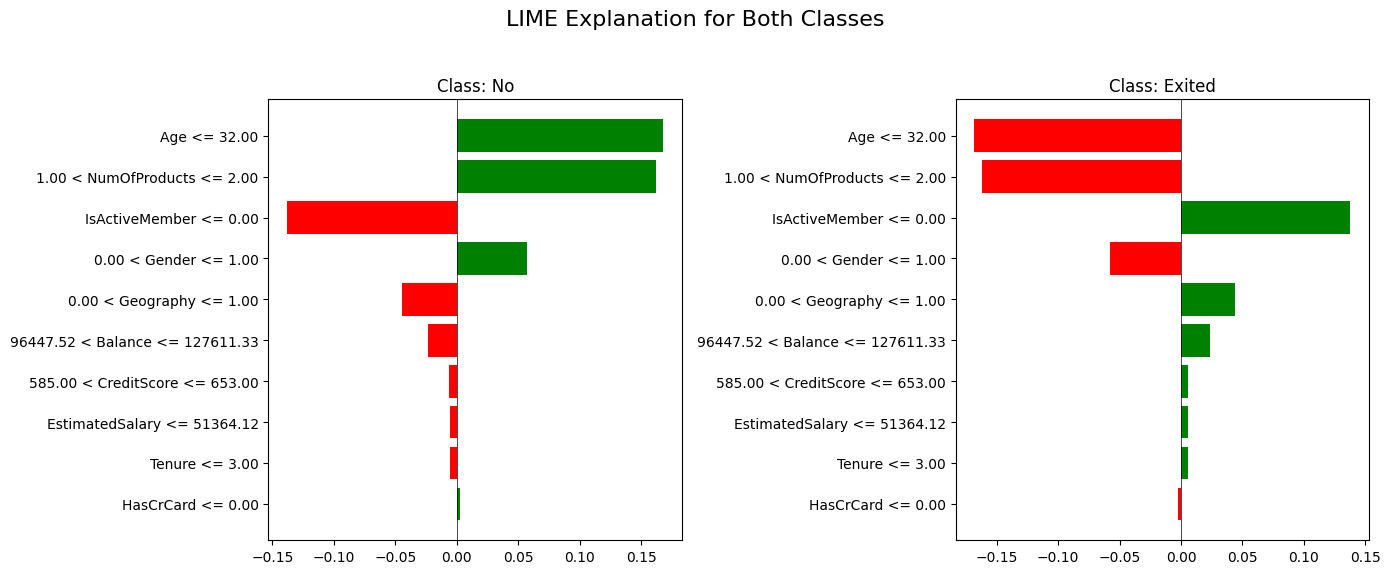

In [31]:
import matplotlib.pyplot as plt

def plot_lime_explanation(lime_exp, label, ax, class_name):
    exp = lime_exp.as_list(label=label)
    features = [x[0] for x in exp]
    weights = [x[1] for x in exp]

    colors = ['green' if w > 0 else 'red' for w in weights]

    ax.barh(features, weights, color=colors)
    ax.set_title(f"Class: {class_name}")
    ax.axvline(0, color='black', linewidth=0.5)
    ax.invert_yaxis()  # Highest weight on top

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("LIME Explanation for Both Classes", fontsize=16)

# Plot manually for both classes
plot_lime_explanation(lime_exp, label=0, ax=axes[0], class_name="No")
plot_lime_explanation(lime_exp, label=1, ax=axes[1], class_name="Exited")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
